In [33]:
import numpy as np
from sklearn.decomposition import PCA 
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import pandas as pd

"""
Loaded in this way, each of the batch files contains a dictionary with the following elements:
data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
"""
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
batch_names = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
path = "./cifar-10-batches-py/"

In [36]:
data = [[] for _ in range(10)] #index is the label
for batch_name in batch_names:
    d = unpickle(path+batch_name)
    batch_data, batch_labels = d[b'data'], d[b'labels']
    for i in range(len(batch_labels)):
        data[batch_labels[i]].append(batch_data[i])
data = np.array(data).astype(float)
#The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class
print(data.shape)


(10, 6000, 3072)


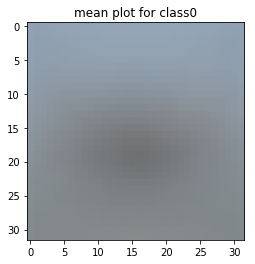

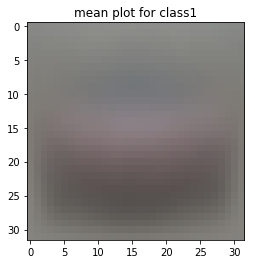

In [ ]:
#Part A
"""
For each class, find the mean image, and compute the first 20 principal components.
Now use the mean as well as the principle components to compute a low-dimensional reconstruction of each image in the class. Hint: Libary functions will come in handy here. Refer to section 7.1.2 and 7.1.3 for theory.
Now for each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels. If you have flattened your images, this is simply the squared euclidean distance between the image vectors. Take the average of the value you computed above over all images in the class.
Plot the above value in the bar graph against its category/class label. You will submit this plot.
"""
pca = PCA(20)
MSEs = []
means = []
for label in range(10):
    mean = np.mean(data[label], axis=0)
    means += [mean]
    r, g, b = mean[:32*32].reshape(32,32), mean[32*32: 32*32*2].reshape(32,32), mean[32*32*2:].reshape(32,32)
    plot_data = np.ndarray((32,32,3))
    plot_data[:,:,0], plot_data[:,:,1], plot_data[:,:,2] = r,g,b 
    plt.imshow(plot_data.astype(int))
    plt.title("mean plot for class{}".format(label))
    plt.show()
    #find the 
    data_proj = pca.fit_transform(data[label])
    data_rec = pca.inverse_transform(data_proj)
    MSEs += [np.mean(np.sum(np.square(data[label]-data_rec), axis=1),axis=0)]
    
plt.figure()
plt.bar(range(10),MSEs)
plt.title("MSE for each class")
plt.xlabel("class label")
plt.ylabel("MSE")
plt.show()

    
    


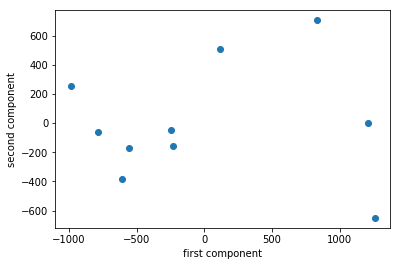

In [21]:
#Part B
"""
Compute a 10 x 10 distance matrix D such that D[i,j] is the Euclidean distance between the mean images of class i and class j. Square the elements of this matrix and write it out to a CSV file named partb_distances.csv. You will submit this file.
Note: The order of the class labels is very important here, as this file will be autograded. Refer to this for the index-label mapping, and ensure yours matches.
Now you must perform multi-dimensional scaling with the squared distance matrix you have. Refer to the MDS section for details on how to do that.
Once you have computed the scaled points in 2-D space, plot the first component along the x-axis and component 2 along the y-axis of a scatter plot. You will submit this plot.
"""
D = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        D[i][j] = np.sum(pdist([means[i], means[j]]))
D = np.square(D)
D_df = pd.DataFrame(D)
D_df.to_csv("partb_distances.csv", index=False, header=None)

def MDS(D, dim):
    A = np.identity(len(D)) - np.ones_like(D) * 1/len(D)
    W = -1/2 * np.dot(np.dot(A, D), A.T)
    eig_values, eig_mat = np.linalg.eig(W)
    Lambda_s = np.diag(eig_values[:dim])
    U_s = eig_mat[:,:dim]
    Y = np.dot(U_s, np.sqrt(Lambda_s))
    return Y

Y = MDS(D, 2)
plt.figure()
plt.xlabel("first component")
plt.ylabel("second component")
plt.scatter(Y[:,0], Y[:,1])
    


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


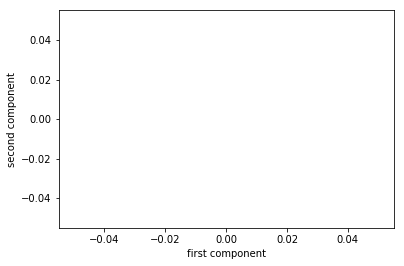

In [32]:
#part3
def E1(A,B):
    return (E2(A,B) + E2(B,A))/2

def E2(A,B):
    if E2_cache[A][B]:
        return E2_cache[A][B]
    pca_B = PCA(20)
    pca_B.fit(data[B])
    pca_A.components_ = pca_B.components_
    data_rec = np.dot(np.dot(pca_B.components_.T, (data[A]-means[A])),pca_B.components_)
    return np.mean(np.sum(np.square(data[label]-data_rec), axis=1),axis=0)

E2_cache = [[None for _ in range(10)] for _ in range(10)]
D = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        if D[j][i] != 0:
            D[i][j] = D[j][i]
        else:
            D[i][j] = E1(i,j)
D_df = pd.DataFrame(D)
D_df.to_csv("partc_distances.csv", index=False, header=None)

Y = MDS(D, 2)
plt.figure()
plt.xlabel("first component")
plt.ylabel("second component")
plt.scatter(Y[:,0], Y[:,1])
